# **Quantum Teleportation**

#### Quantum teleportation is a process by which an unknown quantum state is transfered from a quantum particle to another quantum particle, without physically moving them. Here in 4 steps, described bellow, we constrcut a quantum circuit including 3 quantum particles in which transmit the quantum state of one of the qubits using the shared entanglement between the sender (Alice) and the receiver (Bob).

#### Importing the necessary libraries:

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_bloch_multivector, array_to_latex
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.circuit.library import Initialize

## **Step 1:** Initiating the state
#### As mentioned in the begining, the state of the qubit, that is supposed to be teleported,  can stay unknown. To keep this, we define a randome state for the qubit in a general form of a superposition:
$$
|\psi \rangle = \alpha |0\rangle + \beta|1\rangle.
$$


In [2]:
# create a random 2-dimensional vector 
psi = random_statevector(2)

print('psi state is: ', psi)

# represent the state in a PDF format 
array_to_latex(psi)

psi state is:  Statevector([-0.48846049-0.50226985j,  0.68196236+0.20990162j],
            dims=(2,))


<IPython.core.display.Latex object>

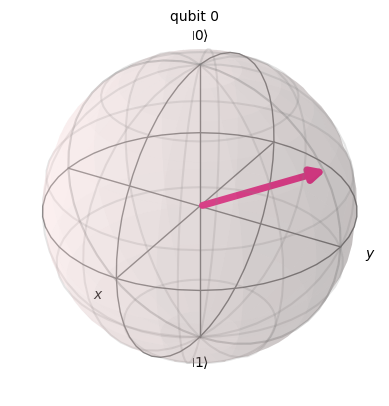

In [3]:
# visualize the state in the Bloch sphere
plot_bloch_multivector(psi)

In [4]:
# place the created random vector psi as the initial state for a qubit that we want to teleported
init_state = Initialize(psi)

init_state.label = "initial_state"

## **Step 2:** Creating entangelement between two qubits shared between Alice and Bob
#### To entangle a pair of qubits, we use the combination of Hadamard gate and CNOT gate. Since the default state of each qubit in qiskit is $\ket 0$, applying the Hadamard gate to the 1st qubit transforms its state from $\ket 0$ to 
$$
H|0\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) 
$$
#### So, after this step, the combined state of the system (in the little endian) becomes:
$$
\frac{1}{\sqrt{2}} |0\rangle \otimes \left( |0\rangle + |1\rangle \right) = \frac{1}{\sqrt{2}} \left( |00\rangle + |01\rangle \right)
$$
#### Now applying a $CNOT$ gate to both qubits where the 1rst qubit acts as the control and the 2nd qubit plays the target role, we will reach the Bell states $\ket\Phi^{+}$ as
$$
|\Phi^{+}\rangle  = \frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)
$$
#### The following function goes through these steps. 

In [5]:
def create_Bell_pair(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

## **Step 3:** Alice's gates to entagle her qubit with the $\ket\psi$
#### In this step, Alice applies the reverse sequence of Hadamard and $CNOT$ gates to entangle her qubit with the qubit with state $\ket\psi$. 
$$
(I \otimes I \otimes H)(I \otimes CNOT)|\Phi^{+}\rangle |\psi \rangle = \frac{1}{2} \Big[ (\alpha |0\rangle + \beta |1\rangle) |00\rangle + (\beta |0\rangle + \alpha |1\rangle) |10\rangle\nonumber\\
(\alpha |0\rangle - \beta |1\rangle) |01\rangle + (-\beta |0\rangle + \alpha |1\rangle) |11\rangle\Big]
$$

In [6]:
def alice_gates(qc,psi,a):
    qc.cx(psi,a)
    qc.h(psi)

## **Step 4:** Measurement by Alice
#### Alice makes a measurment on her part of the entangled pair and the qubit she wants to teleport. Afterwards she sends the result of her measurement (as two classical bits) to Bob via a classical communication channel. According to the equation presented in the step 3, the result of Alice's measurment is 4 standard possible states $\{00, 01, 10, 11\}$ with the same probability of $1/4$. Depending on the result of her measurement, Bob's state will be projected to 
$$
|00\rangle \rightarrow (\alpha |0\rangle + \beta |1\rangle)  \nonumber\\
|10\rangle \rightarrow (\beta |0\rangle + \alpha |1\rangle) \nonumber\\
|01\rangle \rightarrow (\alpha |0\rangle - \beta |1\rangle) \nonumber\\
|11\rangle \rightarrow (-\beta |0\rangle + \alpha |1\rangle) \nonumber
$$ 

In [7]:
def measure_and_send(qc, a, b):
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b,1)

## **Step 5:** Choosing a proper gate by Bob 
#### In order to to recognise the $\alpha$ and $\beta$ using classical bits sent by Alice, Bob should apply a gate to get the state of $\ket\psi$:
$$
\begin{array}{|ccc|} \hline
\text{State} & \text{Classical bit} & \text{Gate} \\ \hline
\alpha |0\rangle + \beta |1\rangle & 00 & I \\ 
 \beta |0\rangle + \alpha |1\rangle & 10 & X \\ 
\alpha |0\rangle - \beta |1\rangle & 01 & Z \\ 
-\beta |0\rangle + \alpha |1\rangle & 11 & ZX \\ \hline
\end{array}
$$


In [10]:
def bob_gates(qc, qubit,crx,crz):
    qc.x(qubit).c_if(crx,1) # c_if: classical if
    qc.z(qubit).c_if(crz,1)

## Constructing the Circuit
#### Now we apply all the functions defined for different steps:

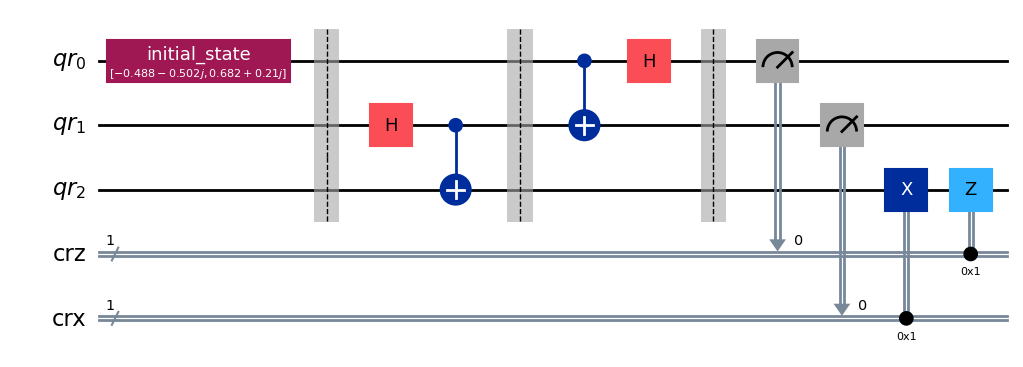

In [11]:
# qubits in the following order
# 0:qubit to teleport, 1: Alice's qubit, 2: Bob's qubit
qr = QuantumRegister(3, name = 'qr')

# calssical bits
crz = ClassicalRegister(1, name ='crz')
crx = ClassicalRegister(1, name = 'crx')


# defining the circuit
qc = QuantumCircuit(qr, crz, crx)

#step 1
qc.append(init_state, [0]) # apply to |0> state
qc.barrier()

#step 2
create_Bell_pair(qc, 1, 2)
qc.barrier()

# step 3
alice_gates(qc,0,1)

# step 4
measure_and_send(qc, 0,1)

# step 5
bob_gates(qc, 2,crx,crz)

qc.draw('mpl')

### Check the result of Teleportation


 The quantum state of each qubit is: Statevector([ 0.   +0.j   ,  0.   +0.j   , -0.488-0.502j,  0.   +0.j   ,
              0.   -0.j   ,  0.   +0.j   ,  0.682+0.21j ,  0.   +0.j   ],
            dims=(2, 2, 2))


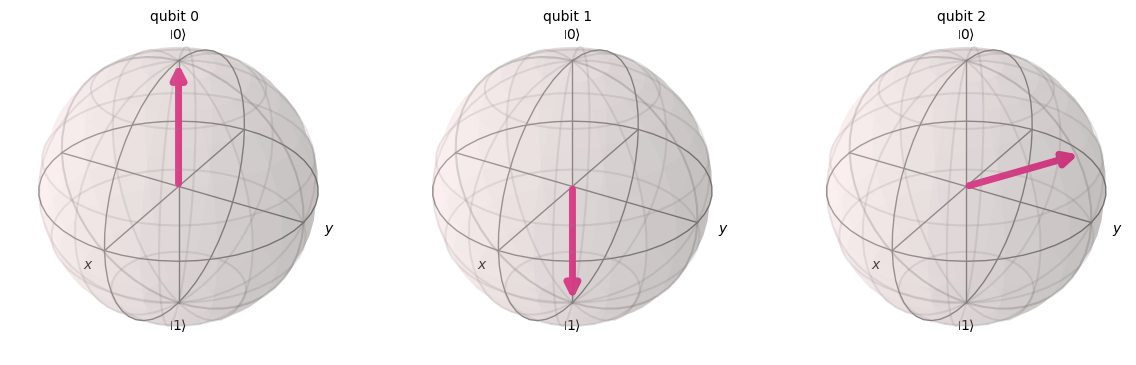

In [12]:
# initiate
estimator = Aer.get_backend("statevector_simulator")

# run
job = estimator.run(qc, decimals = 3)

# results
psi_mes = job.result().get_statevector(qc, decimals = 3)

print('\n The quantum state of each qubit is:' , psi_mes)

plot_bloch_multivector(psi_mes)

#### Comparing the state of qubi 2 with the random state created in step 1 confirms that the teleportation has been done successfully and Bob has turned his qubit state to $\ket \psi$ even without knowing $\alpha$ and $\beta$ coefficients.